<a href="https://colab.research.google.com/github/amalmon/Book-recommendation-system/blob/main/Book_recommendation_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

During the last few decades, with the rise of Youtube, Amazon, Netflix, and many other such web services, recommender systems have taken more and more place in our lives. From e-commerce (suggest to buyers articles that could interest them) to online advertisement (suggest to users the right contents, matching their preferences), recommender systems are today unavoidable in our daily online journeys. In a very general way, recommender systems are algorithms aimed at suggesting relevant items to users (items being movies to watch, text to read, products to buy, or anything else depending on industries).
Recommender systems are really critical in some industries as they can generate a huge amount of income when they are efficient or also be a way to stand out significantly from competitors. The main objective is to create a book recommendation system for users.

Content
The Book-Crossing dataset comprises 3 files.

● Users

Contains the users. Note that user IDs (User-ID) have been anonymized and map to
integers. Demographic data is provided (Location, Age) if available. Otherwise, these fields contain NULL values.


● Books

Books are identified by their respective ISBN. Invalid ISBNs have already been removed from the dataset. Moreover, some content-based information is given (Book-Title, Book-Author, Year-Of-Publication, Publisher), obtained from Amazon Web Services. Note that in the case of several authors, only the first is provided. URLs linking to cover images are also given, appearing in three different flavors (Image-URL-S, Image-URL-M, Image-URL-L), i.e., small, medium, large. These URLs point to the Amazon website.


● Ratings

Contains the book rating information. Ratings (Book-Rating) are either explicit,
expressed on a scale from 1-10 (higher values denoting higher appreciation), or implicit,
expressed by 0.

In [2]:
import numpy as np
import pandas as pd

In [3]:
import scipy
import math
import random
import sklearn
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.linalg import svds
import matplotlib.pyplot as plt

In [4]:
books=pd.read_csv("/content/drive/MyDrive/Almabetter/capstone projects/CAPSTONE-PROJECT-4-RECOMMENDATION SYSTEM/Books.csv")
users=pd.read_csv("/content/drive/MyDrive/Almabetter/capstone projects/CAPSTONE-PROJECT-4-RECOMMENDATION SYSTEM/Users.csv")
ratings=pd.read_csv("/content/drive/MyDrive/Almabetter/capstone projects/CAPSTONE-PROJECT-4-RECOMMENDATION SYSTEM/Ratings.csv")

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


**fetching basic idea about data set by first 5 entries**

In [5]:
#head of book data set
books.head()

ISBN                                         Book-Title  \
0  0195153448                                Classical Mythology   
1  0002005018                                       Clara Callan   
2  0060973129                               Decision in Normandy   
3  0374157065  Flu: The Story of the Great Influenza Pandemic...   
4  0393045218                             The Mummies of Urumchi   

            Book-Author Year-Of-Publication                   Publisher  \
0    Mark P. O. Morford                2002     Oxford University Press   
1  Richard Bruce Wright                2001       HarperFlamingo Canada   
2          Carlo D'Este                1991             HarperPerennial   
3      Gina Bari Kolata                1999        Farrar Straus Giroux   
4       E. J. W. Barber                1999  W. W. Norton &amp; Company   

                                         Image-URL-S  \
0  http://images.amazon.com/images/P/0195153448.0...   
1  http://images.amazon.com/images/P/0002005018.0...   
2  http://images.amazon.com/images/P/0060973129.0...   
3  http://images.amazon.com/images/P/0374157065.0...   
4  http://images.amazon.com/images/P/0393045218.0...   

                                         Image-URL-M  \
0  http://images.amazon.com/images/P/0195153448.0...   
1  http://images.amazon.com/images/P/0002005018.0...   
2  http://images.amazon.com/images/P/0060973129.0...   
3  http://images.amazon.com/images/P/0374157065.0...   
4  http://images.amazon.com/images/P/0393045218.0...   

                                         Image-URL-L  
0  http://images.amazon.com/images/P/0195153448.0...  
1  http://images.amazon.com/images/P/0002005018.0...  
2  http://images.amazon.com/images/P/0060973129.0...  
3  http://images.amazon.com/images/P/0374157065.0...  
4  http://images.amazon.com/images/P/0393045218.0...

In [6]:
#head of users data set
users.head()

User-ID                            Location   Age
0        1                  nyc, new york, usa   NaN
1        2           stockton, california, usa  18.0
2        3     moscow, yukon territory, russia   NaN
3        4           porto, v.n.gaia, portugal  17.0
4        5  farnborough, hants, united kingdom   NaN

In [7]:
#head of rating data set
ratings.head()

User-ID        ISBN  Book-Rating
0   276725  034545104X            0
1   276726  0155061224            5
2   276727  0446520802            0
3   276729  052165615X            3
4   276729  0521795028            6

**figure out structure of data sets**

In [8]:
#for printing shape of all data set
print(books.shape)
print(users.shape)
print(ratings.shape)

(271360, 8)
(278858, 3)
(1149780, 3)


**Searching for null values of data sets (if there any)**

In [9]:
#for total of null values in books data set
books.isnull().sum()

ISBN                   0
Book-Title             0
Book-Author            1
Year-Of-Publication    0
Publisher              2
Image-URL-S            0
Image-URL-M            0
Image-URL-L            3
dtype: int64

In [10]:
#for total of null values in users data set
users.isnull().sum()

User-ID          0
Location         0
Age         110762
dtype: int64



*   Basically, missing values of age column will not much more affect on our final aim recommendation




In [11]:
#for total of null values in ratings data set
ratings.isnull().sum()

User-ID        0
ISBN           0
Book-Rating    0
dtype: int64

**finding any duplicate entries are there**

In [12]:
#tot. of duplicate entries in books
books.duplicated().sum()

0

In [13]:
#tot. of duplicate entries in users
users.duplicated().sum()

0

In [14]:
#tot. of duplicate entries in ratings
ratings.duplicated().sum()

0

In [15]:
books.Publisher.unique().size

16808

In [16]:
books['Year-Of-Publication'].unique().size

202

In [17]:
books['Book-Title'].unique().size

242135

In [18]:
books['Book-Author'].unique().size

102024

In [19]:
users.Location.unique().size

57339

### **Pre processing of datasets**



*  dropping Null value entries, as a best option for recommendation system.and also there is no possibility to fill with approximate values or it is not much worth here.
*  dropping 2 of 3 image url columns and holding large image url column
*  dropping user id column which is not needed



In [20]:
#droping null values of books dataset
books.dropna(inplace=True)

In [21]:
#droping columns 'Image-URL-S','Image-URL-M'
books.drop(columns=['Image-URL-S','Image-URL-M'],inplace=True)

In [22]:
books.shape

(271354, 6)

In [23]:
books.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 271354 entries, 0 to 271359
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271354 non-null  object
 1   Book-Title           271354 non-null  object
 2   Book-Author          271354 non-null  object
 3   Year-Of-Publication  271354 non-null  object
 4   Publisher            271354 non-null  object
 5   Image-URL-L          271354 non-null  object
dtypes: object(6)
memory usage: 14.5+ MB


In [24]:
# merging rating dataset and books dataset
books_with_rating=ratings.merge(books,on='ISBN')

In [25]:
books_with_rating

User-ID        ISBN  Book-Rating  \
0         276725  034545104X            0   
1           2313  034545104X            5   
2           6543  034545104X            0   
3           8680  034545104X            5   
4          10314  034545104X            9   
...          ...         ...          ...   
1031124   276688  0517145553            0   
1031125   276688  1575660792            7   
1031126   276690  0590907301            0   
1031127   276704  0679752714            0   
1031128   276704  0806917695            5   

                                                Book-Title      Book-Author  \
0                                     Flesh Tones: A Novel       M. J. Rose   
1                                     Flesh Tones: A Novel       M. J. Rose   
2                                     Flesh Tones: A Novel       M. J. Rose   
3                                     Flesh Tones: A Novel       M. J. Rose   
4                                     Flesh Tones: A Novel       M. J. Rose   
...                                                    ...              ...   
1031124                                    Mostly Harmless    Douglas Adams   
1031125                                        Gray Matter  Shirley Kennett   
1031126  Triplet Trouble and the Class Trip (Triplet Tr...     Debbie Dadey   
1031127  A Desert of Pure Feeling (Vintage Contemporaries)   Judith Freeman   
1031128  Perplexing Lateral Thinking Puzzles: Scholasti...      Paul Sloane   

        Year-Of-Publication                          Publisher  \
0                      2002                   Ballantine Books   
1                      2002                   Ballantine Books   
2                      2002                   Ballantine Books   
3                      2002                   Ballantine Books   
4                      2002                   Ballantine Books   
...                     ...                                ...   
1031124                1995             Random House Value Pub   
1031125                1996  Kensington Publishing Corporation   
1031126                1997                              Apple   
1031127                1997                  Vintage Books USA   
1031128                1997                Sterling Publishing   

                                               Image-URL-L  
0        http://images.amazon.com/images/P/034545104X.0...  
1        http://images.amazon.com/images/P/034545104X.0...  
2        http://images.amazon.com/images/P/034545104X.0...  
3        http://images.amazon.com/images/P/034545104X.0...  
4        http://images.amazon.com/images/P/034545104X.0...  
...                                                    ...  
1031124  http://images.amazon.com/images/P/0517145553.0...  
1031125  http://images.amazon.com/images/P/1575660792.0...  
1031126  http://images.amazon.com/images/P/0590907301.0...  
1031127  http://images.amazon.com/images/P/0679752714.0...  
1031128  http://images.amazon.com/images/P/0806917695.0...  

[1031129 rows x 8 columns]

1.   need to create a avrg. rating column
2.   create no. of rating column

In [26]:
#making avrg_rating df
avrg_df=books_with_rating.groupby('ISBN')['Book-Rating'].mean().reset_index()
avrg_df.columns=['ISBN','Avg.Rating']

In [27]:
avrg_df

ISBN  Avg.Rating
0       0000913154         8.0
1       0001010565         0.0
2       0001046438         9.0
3       0001046713         0.0
4       000104687X         6.0
...            ...         ...
270140  B000234N76         0.0
270141  B000234NC6         0.0
270142  B00029DGGO         0.0
270143  B0002JV9PY         0.0
270144  B0002K6K8O         0.0

[270145 rows x 2 columns]

In [28]:
#merging avrg_df and Book_with_rating
books_with_rating=avrg_df.merge(books_with_rating,on='ISBN')

In [29]:
books_with_rating

ISBN  Avg.Rating  User-ID  Book-Rating  \
0        0000913154         8.0   171118            8   
1        0001010565         0.0    86123            0   
2        0001010565         0.0   209516            0   
3        0001046438         9.0    23902            9   
4        0001046713         0.0   196149            0   
...             ...         ...      ...          ...   
1031124  B000234N76         0.0   264317            0   
1031125  B000234NC6         0.0   100906            0   
1031126  B00029DGGO         0.0   100088            0   
1031127  B0002JV9PY         0.0   179791            0   
1031128  B0002K6K8O         0.0   179791            0   

                                                Book-Title  \
0        The Way Things Work: An Illustrated Encycloped...   
1                                          Mog's Christmas   
2                                          Mog's Christmas   
3                                                     Liar   
4                             Twopence to Cross the Mersey   
...                                                    ...   
1031124                                     Falling Angels   
1031125  It Must've Been Something I Ate: The Return of...   
1031126                        Good Wife Strikes Back, The   
1031127                               The Blockade Runners   
1031128                               The Underground City   

                           Book-Author Year-Of-Publication  \
0        C. van Amerongen (translator)                1967   
1                          Judith Kerr                1992   
2                          Judith Kerr                1992   
3                          Stephen Fry                   0   
4                      Helen Forrester                1992   
...                                ...                 ...   
1031124                Tracy Chevalier                2001   
1031125            Jeffrey Steingarten                2002   
1031126               Elizabeth Buchan                   0   
1031127                    Jules Verne                   0   
1031128                    Jules Verne                   0   

                        Publisher  \
0            Simon &amp; Schuster   
1                         Collins   
2                         Collins   
3                Harpercollins Uk   
4        HarperCollins Publishers   
...                           ...   
1031124                E P Dutton   
1031125                     Knopf   
1031126              Viking Adult   
1031127             Digireads.com   
1031128             Digireads.com   

                                               Image-URL-L  
0        http://images.amazon.com/images/P/0000913154.0...  
1        http://images.amazon.com/images/P/0001010565.0...  
2        http://images.amazon.com/images/P/0001010565.0...  
3        http://images.amazon.com/images/P/0001046438.0...  
4        http://images.amazon.com/images/P/0001046713.0...  
...                                                    ...  
1031124  http://images.amazon.com/images/P/B000234N76.0...  
1031125  http://images.amazon.com/images/P/B000234NC6.0...  
1031126  http://images.amazon.com/images/P/B00029DGGO.0...  
1031127  http://images.amazon.com/images/P/B0002JV9PY.0...  
1031128  http://images.amazon.com/images/P/B0002K6K8O.0...  

[1031129 rows x 9 columns]

In [30]:
#making count of rating df
rating_count_df=books_with_rating['ISBN'].value_counts().reset_index()
rating_count_df.columns=['ISBN','no.of ratings']

In [31]:
rating_count_df

ISBN  no.of ratings
0       0971880107           2502
1       0316666343           1295
2       0385504209            883
3       0060928336            732
4       0312195516            723
...            ...            ...
270140  0590661388              1
270141  0590662082              1
270142  059066218X              1
270143  0590664700              1
270144  B0002K6K8O              1

[270145 rows x 2 columns]

In [32]:
#merging rating_count_df with book_with_rating df
books_with_rating=rating_count_df.merge(books_with_rating,on='ISBN')

In [33]:
books_with_rating

ISBN  no.of ratings  Avg.Rating  User-ID  Book-Rating  \
0        0971880107           2502    1.019584   276925            0   
1        0971880107           2502    1.019584   276939            0   
2        0971880107           2502    1.019584   276954            0   
3        0971880107           2502    1.019584   277042            2   
4        0971880107           2502    1.019584   277157            0   
...             ...            ...         ...      ...          ...   
1031124  0590661388              1    7.000000    14079            7   
1031125  0590662082              1    0.000000   278418            0   
1031126  059066218X              1    0.000000   278418            0   
1031127  0590664700              1    7.000000   102460            7   
1031128  B0002K6K8O              1    0.000000   179791            0   

                                                Book-Title  \
0                                              Wild Animus   
1                                              Wild Animus   
2                                              Wild Animus   
3                                              Wild Animus   
4                                              Wild Animus   
...                                                    ...   
1031124  Teaching the Stories and Poems of Edgar Allan ...   
1031125          A Bug, a Bear, and a Boy: Paint a Picture   
1031126            A Bug, a Bear, and a Boy Gof for a Ride   
1031127            Portraits of Little Women (Amy's Story)   
1031128                               The Underground City   

                Book-Author Year-Of-Publication                    Publisher  \
0              Rich Shapero                2004                      Too Far   
1              Rich Shapero                2004                      Too Far   
2              Rich Shapero                2004                      Too Far   
3              Rich Shapero                2004                      Too Far   
4              Rich Shapero                2004                      Too Far   
...                     ...                 ...                          ...   
1031124       Tara McCarthy                1999                   Scholastic   
1031125       David McPhail                1998  Scholastic SeeSaw Book Club   
1031126       David McPhail                1998                   Scholastic   
1031127  Susan Beth Pfeffer                1997                   Scholastic   
1031128         Jules Verne                   0                Digireads.com   

                                               Image-URL-L  
0        http://images.amazon.com/images/P/0971880107.0...  
1        http://images.amazon.com/images/P/0971880107.0...  
2        http://images.amazon.com/images/P/0971880107.0...  
3        http://images.amazon.com/images/P/0971880107.0...  
4        http://images.amazon.com/images/P/0971880107.0...  
...                                                    ...  
1031124  http://images.amazon.com/images/P/0590661388.0...  
1031125  http://images.amazon.com/images/P/0590662082.0...  
1031126  http://images.amazon.com/images/P/059066218X.0...  
1031127  http://images.amazon.com/images/P/0590664700.0...  
1031128  http://images.amazon.com/images/P/B0002K6K8O.0...  

[1031129 rows x 10 columns]

In [34]:
books_with_rating.shape

(1031129, 10)

# **E D A**

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

**TOP 15 MOST POPULAR AUTHORS**

In [36]:
authors_value_count=books_with_rating['Book-Author'].value_counts().reset_index()
authors_value_count.columns=['Author','count']
top_author_counts=authors_value_count.sort_values('count',ascending=False)


In [37]:
top_author_counts

Author  count
0                     Stephen King  10053
1                     Nora Roberts   8429
2                     John Grisham   6010
3                  James Patterson   5845
4               Mary Higgins Clark   4777
...                            ...    ...
68735               Mary Jo Salter      1
68736                  SILVA MEHTA      1
68737             Lucretia Stewart      1
68738   Valerian Ivanovich Albanov      1
101584                Geoff Edgers      1

[101585 rows x 2 columns]

[]

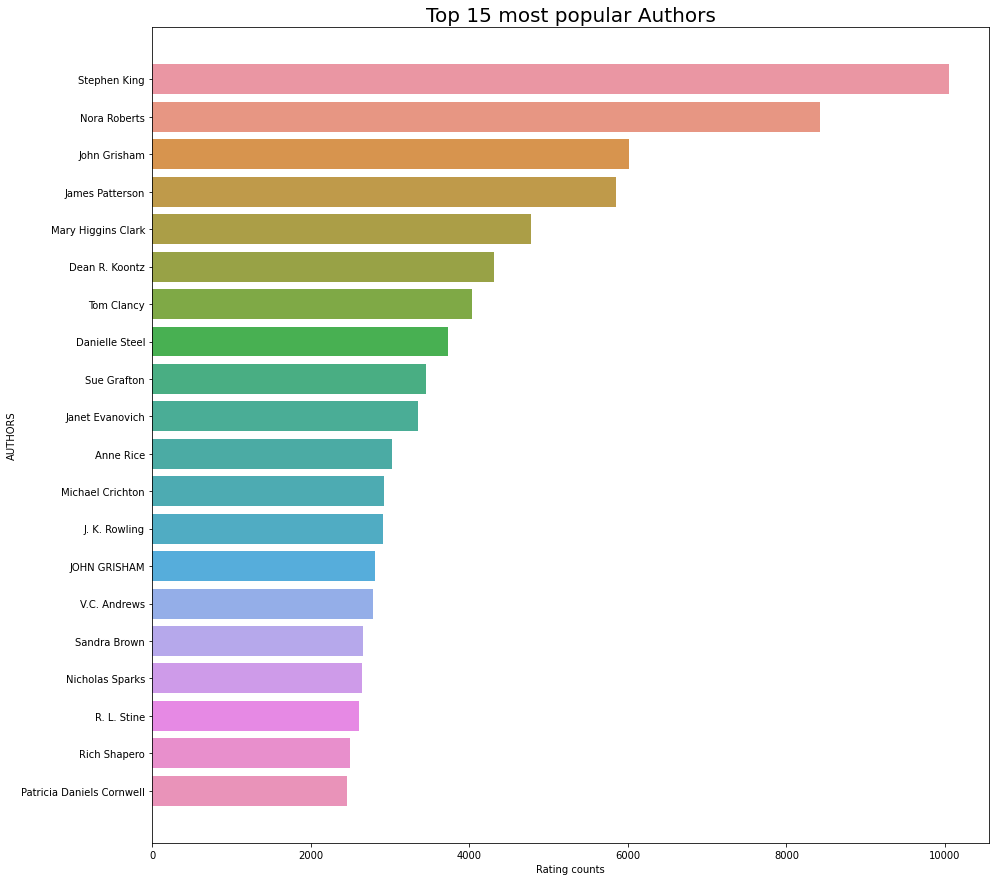

In [38]:
plt.figure(figsize=(15,15))
sns.barplot(data=top_author_counts.head(20),y='Author',x='count')
plt.ylabel('AUTHORS')
plt.xlabel('Rating counts')
plt.title('Top 15 most popular Authors',fontsize = 20)
plt.plot()

**BAR PLOT OF RATINGS**


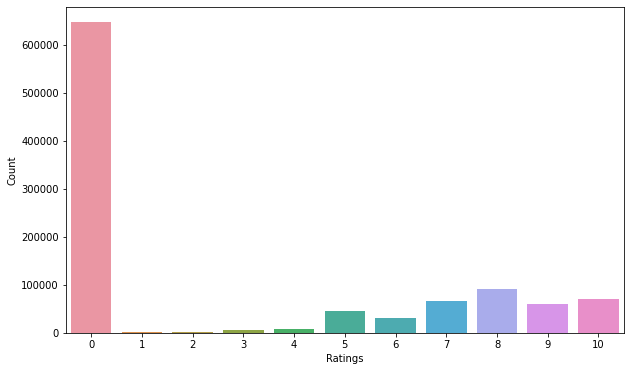

In [39]:
plt.figure(figsize=(10,6))
sns.countplot(data = books_with_rating, x = 'Book-Rating')
plt.xlabel('Ratings')
plt.ylabel('Count')
plt.show()

**TOP 30 MOST REVIEWED/READED BOOKS**

In [40]:
most_read = books_with_rating['Book-Title'].value_counts().reset_index()
most_read.columns = ['bookTitle','count']

most_read

bookTitle  count
0                                             Wild Animus   2502
1                               The Lovely Bones: A Novel   1295
2                                       The Da Vinci Code    898
3                                         A Painted House    838
4                              The Nanny Diaries: A Novel    828
...                                                   ...    ...
241061  Why Am I Afraid to Love?: Overcoming Rejection...      1
241062                                         12 Stories      1
241063                                You Have a Ministry      1
241064                      A Divine Revelation of Heaven      1
241065                               The Underground City      1

[241066 rows x 2 columns]

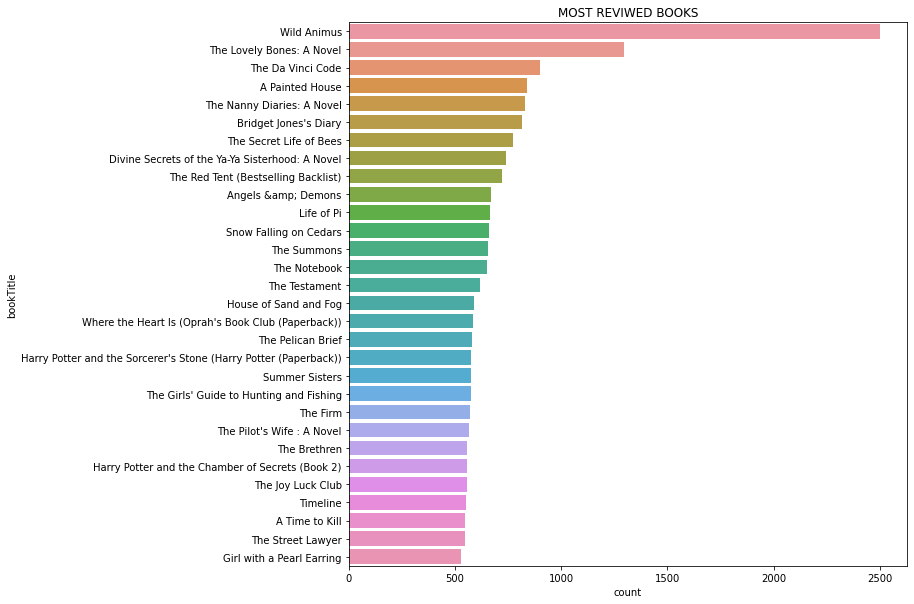

In [41]:
plt.figure(figsize = (10,10))
plt.title("MOST REVIWED BOOKS")
sns.barplot(x = 'count', y = 'bookTitle', data = most_read.head(30))

**AVERAGE RATINGS OF MOST REVIEWED BOOKS**

In [42]:
avg_rating_data = books_with_rating.groupby('Book-Title', as_index=False)['Book-Rating'].mean()
rating_count_data = books_with_rating['Book-Title'].value_counts().reset_index()
rating_count_data.columns = ['Book-Title','count']
most_rated_by_reads = pd.merge(avg_rating_data,rating_count_data,on='Book-Title')

In [43]:
most_rated_by_reads

Book-Title  Book-Rating  count
0        A Light in the Storm: The Civil War Diary of ...     2.250000      4
1                                   Always Have Popsicles     0.000000      1
2                    Apple Magic (The Collector's series)     0.000000      1
3        Ask Lily (Young Women of Faith: Lily Series, ...     8.000000      1
4        Beyond IBM: Leadership Marketing and Finance ...     0.000000      1
...                                                   ...          ...    ...
241061                                      Ã?Â?lpiraten.     0.000000      2
241062                     Ã?Â?rger mit Produkt X. Roman.     5.250000      4
241063                                Ã?Â?sterlich leben.     7.000000      1
241064                              Ã?Â?stlich der Berge.     2.666667      3
241065                                  Ã?Â?thique en toc     4.000000      2

[241066 rows x 3 columns]

In [44]:
most_rated_by_reads = most_rated_by_reads.sort_values('count',ascending=False)

In [45]:
most_rated_by_reads

Book-Title  Book-Rating  count
234946                                        Wild Animus     1.019584   2502
196322                          The Lovely Bones: A Novel     4.468726   1295
183569                                  The Da Vinci Code     4.642539    898
5303                                      A Painted House     3.231504    838
199233                         The Nanny Diaries: A Novel     3.530193    828
...                                                   ...          ...    ...
147558  Real Marriage Material (Silhouette Romance, No...     0.000000      1
63663   Fabulous Fragrances II : A Guide to Prestige P...    10.000000      1
147556  Real Love: The Truth About Finding Uncondition...     0.000000      1
147555                   Real Love: The Drawings for Sean    10.000000      1
168796  Suburban backlash: The battle for the world's ...     0.000000      1

[241066 rows x 3 columns]

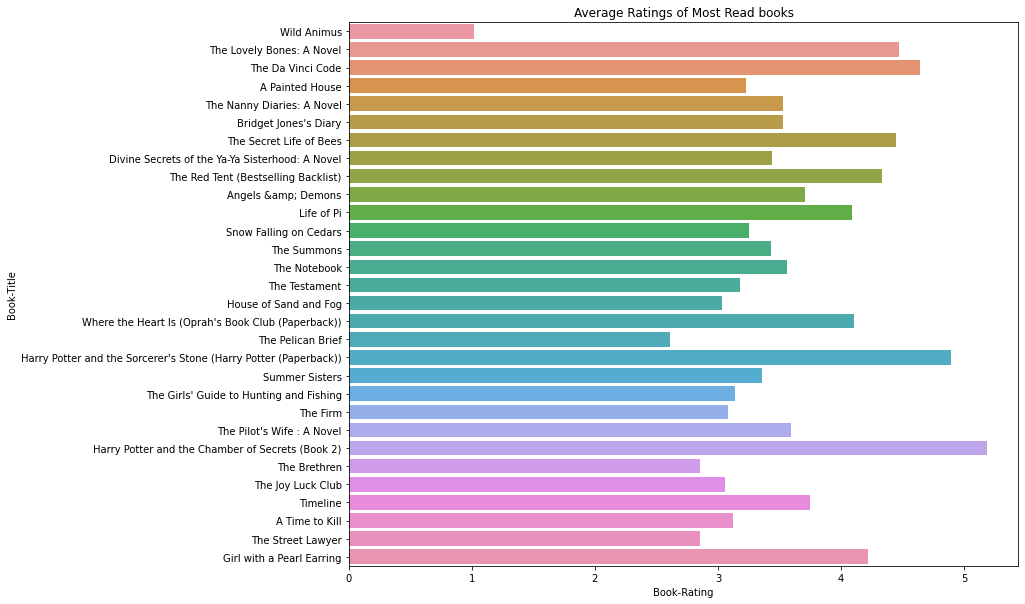

In [46]:
plt.figure(figsize=(12,10))
plt.title("Average Ratings of Most Read books")
sns.barplot(x = 'Book-Rating', y = 'Book-Title', data = most_rated_by_reads.head(30))

**TOP 30 PUBLISHERS**

In [47]:
top_publisher = books_with_rating['Publisher'].value_counts().reset_index()
top_publisher.columns = ['Publisher', 'count']
top_publisher['Publisher'] = top_publisher['Publisher']
top_publisher = top_publisher.sort_values('count',ascending=False)

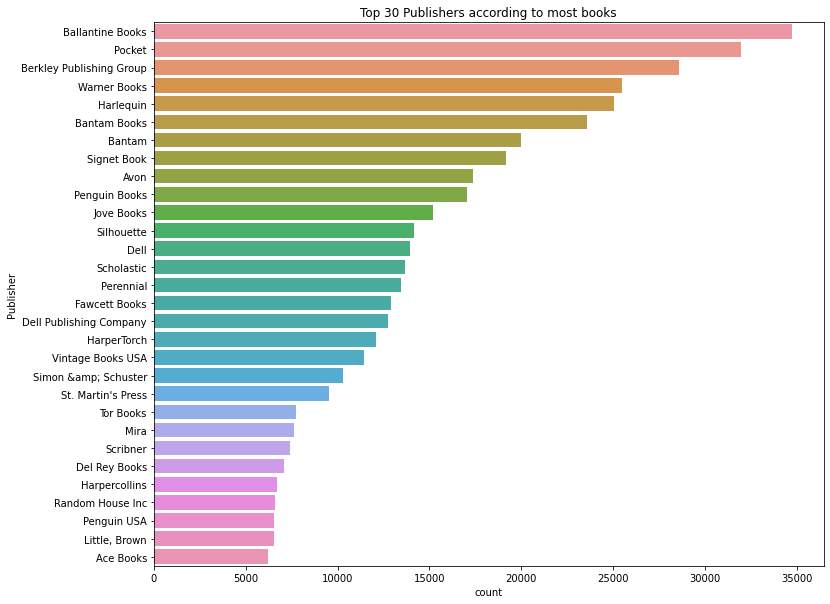

In [48]:
plt.figure(figsize=(12,10))
plt.title('Top 30 Publishers according to most books')
sns.barplot(data = top_publisher.head(30), x = 'count', y = 'Publisher')

**MOST BOOKS PUBLISHING YEAR**

In [49]:
yearOfPublication = books['Year-Of-Publication'].value_counts().reset_index()
yearOfPublication.columns = ['year', 'count']
yearOfPublication = yearOfPublication.sort_values('count',ascending=False)
yearOfPublication

year  count
0    2002  13902
1    2001  13714
2    1999  13414
3    2000  13373
4    1998  12116
..    ...    ...
170  1938      1
169  2024      1
168  1926      1
167  1376      1
199  2037      1

[200 rows x 2 columns]

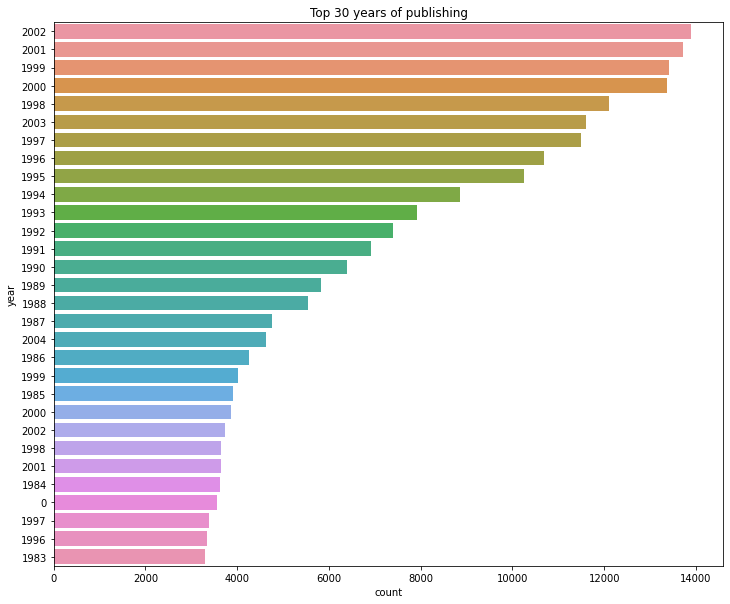

In [50]:
plt.figure(figsize=(12,10))
plt.title('Top 30 years of publishing')
sns.barplot(data = yearOfPublication.head(30), x='count', y='year')

## **POPULARITY BASED RECOMMENDATION SYSTEM**

**when we have a new user, we will face cold start issue in recommendation. we can rely on a popularity based recommendation system in this scenario.**

In [51]:
most_read

bookTitle  count
0                                             Wild Animus   2502
1                               The Lovely Bones: A Novel   1295
2                                       The Da Vinci Code    898
3                                         A Painted House    838
4                              The Nanny Diaries: A Novel    828
...                                                   ...    ...
241061  Why Am I Afraid to Love?: Overcoming Rejection...      1
241062                                         12 Stories      1
241063                                You Have a Ministry      1
241064                      A Divine Revelation of Heaven      1
241065                               The Underground City      1

[241066 rows x 2 columns]

In [52]:
#recalling data frame with book name avrg rating and number of rating
most_rated_by_reads

Book-Title  Book-Rating  count
234946                                        Wild Animus     1.019584   2502
196322                          The Lovely Bones: A Novel     4.468726   1295
183569                                  The Da Vinci Code     4.642539    898
5303                                      A Painted House     3.231504    838
199233                         The Nanny Diaries: A Novel     3.530193    828
...                                                   ...          ...    ...
147558  Real Marriage Material (Silhouette Romance, No...     0.000000      1
63663   Fabulous Fragrances II : A Guide to Prestige P...    10.000000      1
147556  Real Love: The Truth About Finding Uncondition...     0.000000      1
147555                   Real Love: The Drawings for Sean    10.000000      1
168796  Suburban backlash: The battle for the world's ...     0.000000      1

[241066 rows x 3 columns]

In [53]:
#taking books only with above 250 number of rating 
popular_df=most_rated_by_reads[most_rated_by_reads['count']>=250].sort_values('Book-Rating',ascending=False) 

In [54]:
books_with_rating

ISBN  no.of ratings  Avg.Rating  User-ID  Book-Rating  \
0        0971880107           2502    1.019584   276925            0   
1        0971880107           2502    1.019584   276939            0   
2        0971880107           2502    1.019584   276954            0   
3        0971880107           2502    1.019584   277042            2   
4        0971880107           2502    1.019584   277157            0   
...             ...            ...         ...      ...          ...   
1031124  0590661388              1    7.000000    14079            7   
1031125  0590662082              1    0.000000   278418            0   
1031126  059066218X              1    0.000000   278418            0   
1031127  0590664700              1    7.000000   102460            7   
1031128  B0002K6K8O              1    0.000000   179791            0   

                                                Book-Title  \
0                                              Wild Animus   
1                                              Wild Animus   
2                                              Wild Animus   
3                                              Wild Animus   
4                                              Wild Animus   
...                                                    ...   
1031124  Teaching the Stories and Poems of Edgar Allan ...   
1031125          A Bug, a Bear, and a Boy: Paint a Picture   
1031126            A Bug, a Bear, and a Boy Gof for a Ride   
1031127            Portraits of Little Women (Amy's Story)   
1031128                               The Underground City   

                Book-Author Year-Of-Publication                    Publisher  \
0              Rich Shapero                2004                      Too Far   
1              Rich Shapero                2004                      Too Far   
2              Rich Shapero                2004                      Too Far   
3              Rich Shapero                2004                      Too Far   
4              Rich Shapero                2004                      Too Far   
...                     ...                 ...                          ...   
1031124       Tara McCarthy                1999                   Scholastic   
1031125       David McPhail                1998  Scholastic SeeSaw Book Club   
1031126       David McPhail                1998                   Scholastic   
1031127  Susan Beth Pfeffer                1997                   Scholastic   
1031128         Jules Verne                   0                Digireads.com   

                                               Image-URL-L  
0        http://images.amazon.com/images/P/0971880107.0...  
1        http://images.amazon.com/images/P/0971880107.0...  
2        http://images.amazon.com/images/P/0971880107.0...  
3        http://images.amazon.com/images/P/0971880107.0...  
4        http://images.amazon.com/images/P/0971880107.0...  
...                                                    ...  
1031124  http://images.amazon.com/images/P/0590661388.0...  
1031125  http://images.amazon.com/images/P/0590662082.0...  
1031126  http://images.amazon.com/images/P/059066218X.0...  
1031127  http://images.amazon.com/images/P/0590664700.0...  
1031128  http://images.amazon.com/images/P/B0002K6K8O.0...  

[1031129 rows x 10 columns]

In [55]:
popular_df=popular_df.merge(books_with_rating,on='Book-Title').drop_duplicates('Book-Title')[['Book-Title','Book-Author','Year-Of-Publication','no.of ratings','Avg.Rating','Image-URL-L',]]

In [56]:
popular_df

Book-Title        Book-Author  \
0      Harry Potter and the Prisoner of Azkaban (Book 3)      J. K. Rowling   
428         Harry Potter and the Goblet of Fire (Book 4)      J. K. Rowling   
815       Harry Potter and the Sorcerer's Stone (Book 1)      J. K. Rowling   
1093   Harry Potter and the Order of the Phoenix (Boo...      J. K. Rowling   
1440    Harry Potter and the Chamber of Secrets (Book 2)      J. K. Rowling   
...                                                  ...                ...   
71038       Vinegar Hill (Oprah's Book Club (Paperback))   A. Manette Ansay   
71303                                           Whispers        BELVA PLAIN   
71589                                  Presumed Innocent        Scott Turow   
71883                                       Isle of Dogs  Patricia Cornwell   
72171                                        Wild Animus       Rich Shapero   

      Year-Of-Publication  no.of ratings  Avg.Rating  \
0                    2001            226    5.345133   
428                  2000            194    6.541237   
815                  1998            168    6.363095   
1093                 2003            334    5.571856   
1440                 2000            351    4.729345   
...                   ...            ...         ...   
71038                1998            265    2.245283   
71303                1994             72    2.236111   
71589                1989            182    2.401099   
71883                2002            203    1.866995   
72171                2004           2502    1.019584   

                                             Image-URL-L  
0      http://images.amazon.com/images/P/0439136369.0...  
428    http://images.amazon.com/images/P/0439139597.0...  
815    http://images.amazon.com/images/P/0590353403.0...  
1093   http://images.amazon.com/images/P/043935806X.0...  
1440   http://images.amazon.com/images/P/0439064872.0...  
...                                                  ...  
71038  http://images.amazon.com/images/P/0380730138.0...  
71303  http://images.amazon.com/images/P/0440216745.0...  
71589  http://images.amazon.com/images/P/0446359866.0...  
71883  http://images.amazon.com/images/P/0425182908.0...  
72171  http://images.amazon.com/images/P/0971880107.0...  

[186 rows x 6 columns]

In [57]:
popular_df['Image-URL-L'][0]

'http://images.amazon.com/images/P/0439136369.01.LZZZZZZZ.jpg'

### **COLLABORATIVE FILTERING BASED RECOMMENDATION SYSTEM**

In [58]:
book_with_rating_train_df, book_with_rating_test_df = train_test_split(books_with_rating,
                                   test_size=0.20,
                                   random_state=42)

print('# interactions on Train set: %d' % len(book_with_rating_train_df))
print('# interactions on Test set: %d' % len(book_with_rating_test_df))

# interactions on Train set: 824903
# interactions on Test set: 206226


In [59]:
x=books_with_rating.groupby('User-ID').count()['Book-Rating']>200
more_reviewing_users=x[x].index

In [60]:
filtered_ratings=books_with_rating[books_with_rating['User-ID'].isin(more_reviewing_users)]

In [61]:
y=filtered_ratings.groupby('Book-Title').count()['Book-Rating']>=50
famous_books=y[y].index

In [62]:
final_rating=books_with_rating[books_with_rating['Book-Title'].isin(famous_books)]

In [63]:
#Creating a sparse pivot table with users in rows and items in columns
pt=final_rating.pivot_table(index='Book-Title',columns='User-ID',values='Book-Rating').fillna(0)

In [64]:
pt.transpose()

Book-Title  1984  1st to Die: A Novel  2nd Chance  4 Blondes  \
User-ID                                                        
8            0.0                  0.0         0.0        0.0   
9            0.0                  0.0         0.0        0.0   
14           0.0                  0.0         0.0        0.0   
16           0.0                  0.0         0.0        0.0   
17           0.0                  0.0         0.0        0.0   
...          ...                  ...         ...        ...   
278836       0.0                  0.0         0.0        0.0   
278843       0.0                  0.0         0.0        0.0   
278844       0.0                  0.0         0.0        0.0   
278846       0.0                  0.0         0.0        0.0   
278854       0.0                  0.0         0.0        0.0   

Book-Title  A Bend in the Road  A Case of Need  \
User-ID                                          
8                          0.0             0.0   
9                          0.0             0.0   
14                         0.0             0.0   
16                         0.0             0.0   
17                         0.0             0.0   
...                        ...             ...   
278836                     0.0             0.0   
278843                     0.0             0.0   
278844                     0.0             0.0   
278846                     0.0             0.0   
278854                     0.0             0.0   

Book-Title  A Child Called \It\": One Child's Courage to Survive"  \
User-ID                                                             
8                                                         0.0       
9                                                         0.0       
14                                                        0.0       
16                                                        0.0       
17                                                        0.0       
...                                                       ...       
278836                                                    0.0       
278843                                                    0.0       
278844                                                    0.0       
278846                                                    0.0       
278854                                                    0.0       

Book-Title  A Civil Action  A Day Late and a Dollar Short  A Fine Balance  \
User-ID                                                                     
8                      0.0                            0.0             0.0   
9                      0.0                            0.0             0.0   
14                     0.0                            0.0             0.0   
16                     0.0                            0.0             0.0   
17                     0.0                            0.0             0.0   
...                    ...                            ...             ...   
278836                 0.0                            0.0             0.0   
278843                 0.0                            0.0             0.0   
278844                 0.0                            0.0             0.0   
278846                 0.0                            0.0             0.0   
278854                 0.0                            0.0             0.0   

Book-Title  ...  Winter Solstice  Wish You Well  Without Remorse  \
User-ID     ...                                                    
8           ...              0.0            0.0              0.0   
9           ...              0.0            0.0              0.0   
14          ...              0.0            0.0              0.0   
16          ...              0.0            0.0              0.0   
17          ...              0.0            0.0              0.0   
...         ...              ...            ...              ...   
278836      ...              0.0            0.0              0.0   
2788

In [65]:
users_items_pivot_matrix = pt.values
users_items_pivot_matrix[:10]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [66]:
users_ids = list(pt.index)
users_ids[:10]

['1984',
 '1st to Die: A Novel',
 '2nd Chance',
 '4 Blondes',
 'A Bend in the Road',
 'A Case of Need',
 'A Child Called \\It\\": One Child\'s Courage to Survive"',
 'A Civil Action',
 'A Day Late and a Dollar Short',
 'A Fine Balance']

**SINGULAR VALUE DECOMPOSITION**

In [67]:
# The number of factors to factor the user-item matrix.
NUMBER_OF_FACTORS_MF = 12

#Performs matrix factorization of the original user item matrix
U, sigma, Vt = svds(users_items_pivot_matrix, k = NUMBER_OF_FACTORS_MF)

In [68]:
users_items_pivot_matrix.shape

(706, 34156)

In [69]:
U.shape

(706, 12)

In [70]:
sigma = np.diag(sigma)
sigma.shape

(12, 12)

In [71]:
Vt.shape

(12, 34156)

# After the factorization, we try to to reconstruct the original matrix by multiplying its factors. The resulting matrix is not sparse any more. It was generated predictions for items the user have not yet interaction, which we will exploit for recommendations.

In [72]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 
all_user_predicted_ratings

array([[ 0.        ,  0.02217117,  0.        , ...,  0.0277781 ,
         0.10306305, -0.00279034],
       [ 0.        , -0.0057691 ,  0.        , ...,  0.00135552,
        -0.0335449 ,  0.08563709],
       [ 0.        , -0.00306172,  0.        , ..., -0.00268601,
        -0.03611621,  0.07146975],
       ...,
       [ 0.        ,  0.01423361,  0.        , ...,  0.01154234,
         0.03434595,  0.01029408],
       [ 0.        ,  0.00243727,  0.        , ...,  0.00237672,
        -0.0027637 ,  0.01733521],
       [ 0.        , -0.00287466,  0.        , ...,  0.00387598,
        -0.00579373,  0.0330128 ]])

In [73]:
all_user_predicted_ratings.shape

(706, 34156)

In [1]:
from sklearn.metrics.pairwise import cosine_similarity

In [74]:
Book_Similarity=pd.DataFrame(cosine_similarity(all_user_predicted_ratings),index=list(pt.index),columns=list(pt.index))

In [ ]:
Book_Similarity

In [82]:
# Book Recomendation 
def top5_recomendations(Book):
  return Book_Similarity[Book].nlargest(n=6)[1:]


book=input("Enter the book name  ")
try:
  book_name = str(book)
  print('Top5 Recomendations are'+'\n')
  print(top5_recomendations(book_name))
except:
  print('Invalid book name')

Enter the book name  1984
Top5 Recomendations are

Watership Down                          0.970634
Brave New World                         0.963955
Lord of the Flies                       0.955031
The Hitchhiker's Guide to the Galaxy    0.938931
American Gods                           0.929959
Name: 1984, dtype: float64


In [ ]:
#Converting the reconstructed matrix back to a Pandas dataframe
cf_preds_df = pd.DataFrame(all_user_predicted_ratings, columns = pt.columns, index=users_ids).transpose()
cf_preds_df

1984  1st to Die: A Novel  2nd Chance  4 Blondes  \
User-ID                                                         
8        0.000000             0.000000    0.000000   0.000000   
9        0.022171            -0.005769   -0.003062   0.002195   
14       0.000000             0.000000    0.000000   0.000000   
16       0.024497             0.035985    0.021276   0.001829   
17       0.000000             0.000000    0.000000   0.000000   
...           ...                  ...         ...        ...   
278836   0.006963             0.254667    0.151081  -0.008419   
278843   0.156149            -0.071007   -0.047485   0.046992   
278844   0.027778             0.001356   -0.002686   0.005496   
278846   0.103063            -0.033545   -0.036116   0.006156   
278854  -0.002790             0.085637    0.071470   0.000305   

         A Bend in the Road  A Case of Need  \
User-ID                                       
8                  0.000000        0.000000   
9                  0.008679        0.003857   
14                 0.000000        0.000000   
16                -0.021853        0.018371   
17                 0.000000        0.000000   
...                     ...             ...   
278836            -0.026450        0.015932   
278843             0.091353        0.076087   
278844             0.002980        0.005172   
278846            -0.032554        0.011453   
278854             0.031519        0.022757   

         A Child Called \It\": One Child's Courage to Survive"  \
User-ID                                                          
8                                                 0.000000       
9                                                 0.005677       
14                                                0.000000       
16                                                0.001129       
17                                                0.000000       
...                                                    ...       
278836                                           -0.020041       
278843                                            0.180994       
278844                                            0.009655       
278846                                            0.001173       
278854                                            0.011339       

         A Civil Action  A Day Late and a Dollar Short  A Fine Balance  ...  \
User-ID                                                                 ...   
8              0.000000                       0.000000        0.000000  ...   
9              0.004789                       0.004473        0.006064  ...   
14             0.000000                       0.000000        0.000000  ...   
16             0.003777                      -0.002908       -0.001605  ...   
17             0.000000                       0.000000        0.000000  ...   
...                 ...                            ...             ...  ...   
278836         0.009303                       0.016926        0.019217  ...   
278843         0.070931                       0.042374        0.064942  ...   
278844         0.006377                       0.004671        0.009107  ...   
278846         0.012295                       0.004314        0.007450  ...   
278854         0.007323                       0.008447        0.005630  ...   

         Winter Solstice  Wish You Well  Without Remorse  \
User-ID                                                    
8               0.000000       0.000000         0.000000   
9               0.005746       0.001108         0.000658   
14              0.000000       0.000000         0.000000   
16             -0.003741       0.003496         0.018205   
17              0.000000       0.000000         0.000000   
...                  ...            ...              ...   
278836          0.027052       0.052651        -0.006441   
278843          0.121807      -0.024500        -0.026970   
278844          0.005921       0.001014         0.000889   
278846  

In [ ]:
books_with_rating_train_df,books_with_rating_test_df = train_test_split(books_with_rating, 
                                   test_size=0.20,
                                   random_state=42)

In [ ]:
len(cf_preds_df.columns)

706

**cosine similarity**


In data analysis, cosine similarity is a measure of similarity between two sequences of numbers. For defining it, the sequences are viewed as vectors in an inner product space, and the cosine similarity is defined as the cosine of the angle between them, that is, the dot product of the vectors divided by the product of their lengths. It follows that the cosine similarity does not depend on the magnitudes of the vectors, but only on their angle. The cosine similarity always belongs to the interval [-1,1]. 

For example, two proportional vectors have a cosine similarity of 1, two orthogonal vectors have a similarity of 0, and two opposite vectors have a similarity of -1. The cosine similarity is particularly used in positive space, where the outcome is neatly bounded in [0,1].


 * here we can use cosine similarity to define the similarity between users in frame of all books

 relatively books will be lesser in number as compared to number of users
so, it is better to take books as features and users as different columns







In [ ]:
pt.duplicated().sum()

0

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
similarity_scores = cosine_similarity(pt)

In [ ]:
similarity_scores

array([[1.        , 0.01854548, 0.00247494, ..., 0.03288815, 0.0201523 ,
        0.00912194],
       [0.01854548, 1.        , 0.15414936, ..., 0.01386289, 0.06510479,
        0.05358723],
       [0.00247494, 0.15414936, 1.        , ..., 0.00951411, 0.0162807 ,
        0.02742579],
       ...,
       [0.03288815, 0.01386289, 0.00951411, ..., 1.        , 0.02000555,
        0.00426846],
       [0.0201523 , 0.06510479, 0.0162807 , ..., 0.02000555, 1.        ,
        0.03644179],
       [0.00912194, 0.05358723, 0.02742579, ..., 0.00426846, 0.03644179,
        1.        ]])

In [ ]:
similarity_scores.shape

(706, 706)

###**Defining a function which take book name as input and retun suggested books**

In [ ]:
def recommend(book_title):
  #to find index of book
  index_of_input=np.where(pt.index==book_title)[0][0]
  #top 5 similarity 
  similar_books=sorted(list(enumerate(similarity_scores[index_of_input])),key=lambda x:x[1],reverse=True)[1:6]
  for i in similar_books:
    print(pt.index[i[0]])